In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LIB

In [ ]:
!pip3 install numpy
!pip3 install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 4.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633709 sha256=55355638fe2f75de5dccc91cfb3a86dc6baa0dde401f8add063a20cb9b2c2a85
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np 
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse 
from surprise import Dataset
from surprise.model_selection import KFold
from past.builtins import xrange
from sklearn.metrics import mean_squared_error

# READ DATA

In [ ]:
PATH_TRAIN = '/content/drive/MyDrive/ML/Recommendation_System/Data/ML-1M-SPLIT/TIMESTAMP/train.csv'
PATH_TEST = '/content/drive/MyDrive/ML/Recommendation_System/Data/ML-1M-SPLIT/TIMESTAMP/test.csv'
PATH_VAL = '/content/drive/MyDrive/ML/Recommendation_System/Data/ML-1M-SPLIT/TIMESTAMP/validation.csv'


In [ ]:
train = pd.read_csv(PATH_TRAIN)
test = pd.read_csv(PATH_TEST)
val = pd.read_csv(PATH_VAL)

In [ ]:
train = train[['UserID', 'MovieID', 'Rating']]
test = test[['UserID', 'MovieID', 'Rating']]
val = val[['UserID', 'MovieID', 'Rating']]

# RATING PREDICTION

## User - user 

In [ ]:
class CF(object):
   
    def __init__(self, Y_data, k, dist_func = cosine_similarity, uuCF = 1):
        self.uuCF = uuCF # user-user (1) or item-item (0) CF
        self.Y_data = Y_data if uuCF else Y_data[:, [1, 0, 2]]
        self.k = k # number of neighbor points
        self.dist_func = dist_func
        self.Ybar_data = None
        # number of users and items. Remember to add 1 since id starts from 0
        self.n_users = int(np.max(self.Y_data[:, 0])) + 1 
        self.n_items = int(np.max(self.Y_data[:, 1])) + 1
    
    def normalize_Y(self):
        users = self.Y_data[:, 0] # all users - first col of the Y_data
        self.Ybar_data = self.Y_data.copy()
        self.mu = np.zeros((self.n_users,))
        for n in range(self.n_users):
            # row indices of rating done by user n
            # since indices need to be integers, we need to convert
            ids = np.where(users == n)[0].astype(np.int32)
            # indices of all ratings associated with user n
            item_ids = self.Y_data[ids, 1] 
            # and the corresponding ratings 
            ratings = self.Y_data[ids, 2]
            # take mean
            m = np.mean(ratings) 
            if np.isnan(m):
                m = 0 # to avoid empty array and nan value
            # normalize
            self.Ybar_data[ids, 2] = ratings - self.mu[n]

        ################################################
        # form the rating matrix as a sparse matrix. Sparsity is important 
        # for both memory and computing efficiency. For example, if #user = 1M, 
        # #item = 100k, then shape of the rating matrix would be (100k, 1M), 
        # you may not have enough memory to store this. Then, instead, we store 
        # nonzeros only, and, of course, their locations.
        self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2],
            (self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_items, self.n_users))
        self.Ybar = self.Ybar.tocsr()

    def similarity(self):
        self.S = self.dist_func(self.Ybar.T, self.Ybar.T)
        
     
    def refresh(self):
   
        self.normalize_Y()
        self.similarity() 

    def fit(self):
        self.refresh()
        
             
    
    def __pred(self, u, i): #normalized = 1):
       
        # Step 1: find all users who rated i
        ids = np.where(self.Y_data[:, 1] == i)[0].astype(np.int32)
        # Step 2: 
        users_rated_i = (self.Y_data[ids, 0]).astype(np.int32)
        # Step 3: find similarity btw the current user and others 
        # who already rated i
        sim = self.S[u, users_rated_i]
        # Step 4: find the k most similarity users
        a = np.argsort(sim)[-self.k:] 
        # and the corresponding similarity levels
        nearest_s = sim[a]
        # How did each of 'near' users rated item i
        r = self.Ybar[i, users_rated_i[a]]
#         if normalized:
#             # add a small number, for instance, 1e-8, to avoid dividing by 0
#             return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8)

        return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8) + self.mu[u]
    
    def pred(self, u, i): #normalized = 1):
        if self.uuCF: return self.__pred(u, i)# normalize)
        return self.__pred(i, u) #normalize)
    
    def recommend(self, u, normalized = 1):
        ids = np.where(self.Y_data[:, 0] == u)[0]
        items_rated_by_u = self.Y_data[ids, 1].tolist()              
        recommended_items = []
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                rating = self.__pred(u, i)
                if rating > 0: 
                    recommended_items.append(i)
        
        return recommended_items 
    
    
    def print_recommendation(self):     
        print ('Recommendation: ')
        for u in range(self.n_users):
            recommended_items = self.recommend(u)
            if self.uuCF:
                print (' Recommend item(s):', recommended_items, 'to user', u)
            else: 
                print (' Recommend item', u, 'to user(s) : ', recommended_items)


In [ ]:
rs = CF(train.values, k = 1000, dist_func = cosine_similarity, uuCF = 1)
rs.fit()

n_tests = val.values.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs.pred(val.values[n, 0], val.values[n, 1])
    SE += (pred - val.values[n, 2])**2 

RMSE = np.sqrt(SE/n_tests)
print('Validation User-user CF, RMSE =', RMSE)

n_tests = train.values.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs.pred(train.values[n, 0], train.values[n, 1])
    SE += (pred - train.values[n, 2])**2 

RMSE = np.sqrt(SE/n_tests)
print('Training User-user CF, RMSE =', RMSE)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Validation User-user CF, RMSE = 0.977168729138703
Training User-user CF, RMSE = 0.9545790974088926


## Items- items

In [ ]:
# rs = CF(train.values, k = 1000, dist_func = cosine_similarity, uuCF = 1)
# rs.fit()

# n_tests = val.values.shape[0]
# SE = 0 # squared error
# for n in range(n_tests):
#     pred = rs.pred(val.values[n, 0], val.values[n, 1])
#     SE += (pred - val.values[n, 2])**2 

# RMSE = np.sqrt(SE/n_tests)
# print('Validation User-user CF, RMSE =', RMSE)

# n_tests = train.values.shape[0]
# SE = 0 # squared error
# for n in range(n_tests):
#     pred = rs.pred(train.values[n, 0], train.values[n, 1])
#     SE += (pred - train.values[n, 2])**2 

# RMSE = np.sqrt(SE/n_tests)
# print('Training User-user CF, RMSE =', RMSE)

In [ ]:
rs = CF(train.values, k = 1000, uuCF = 0)
rs.fit()

n_tests = val.values.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs.pred(val.values[n, 0], val.values[n, 1])
    SE += (pred - val.values[n, 2])**2 

RMSE = np.sqrt(SE/n_tests)
print('Validation Items-Items CF, RMSE =', RMSE)

n_tests = train.values.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs.pred(train.values[n, 0], train.values[n, 1])
    SE += (pred - train.values[n, 2])**2 

RMSE = np.sqrt(SE/n_tests)
print('Training Items-Items CF, RMSE =', RMSE)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Validation Items-Items CF, RMSE = 1.0511835530826206
Training Items-Items CF, RMSE = 0.9724570030703779


## SVD

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train[['UserID', 'MovieID', 'Rating']], reader)

In [ ]:
#FINDING ESTIMATOR OF SVD MODEL USING TRAIN SET
def estimator_svd(n_split,inputs):
    from surprise.model_selection import KFold
    from surprise import accuracy
    acc=[]
    kf = KFold(n_splits=n_split)
    algo= SVD()
    models=[]
    for trainset, testset in kf.split(inputs):
        model=algo.fit(trainset)
        models.append(model)
        predictions = algo.test(testset)
        acc.append(accuracy.rmse(predictions, verbose=True))
    return models,acc

modells,accuracy=estimator_svd(2,data)

RMSE: 0.9041
RMSE: 0.9032


In [ ]:
def find_best_estimator_index(arr):
  return np.argmin(arr)

In [ ]:
best_estimator__SVD_index=find_best_estimator_index(accuracy)

In [ ]:
def create_data_for_val_method(df):
    from surprise import accuracy
    reader1 = Reader(rating_scale=(1, 5))
    data1 = Dataset.load_from_df(df[['UserID', 'MovieID', 'Rating']], reader1)
    TrainSet_Val= data1.build_full_trainset()
    TestSet_Val=TrainSet_Val.build_testset()
    return TestSet_Val

def predict(model,test_set):
    from surprise import accuracy
    pred=model.test(test_set)
    return accuracy.rmse(pred,verbose=True)

Test_set=create_data_for_val_method(val)
predict(modells[best_estimator__SVD_index],Test_set)

RMSE: 0.9329


0.9328543861731275

## SVDpp

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train[['UserID', 'MovieID', 'Rating']], reader)

#FINDING ESTIMATOR OF SVDppSVDpp MODEL USING TRAIN SET
def estimator_svd(n_split,inputs):
    from surprise.model_selection import KFold
    from surprise import accuracy
    acc=[]
    kf = KFold(n_splits=n_split)
    algo= SVDpp()
    models=[]
    for trainset, testset in kf.split(inputs):
        model=algo.fit(trainset)
        models.append(model)
        predictions = algo.test(testset)
        acc.append(accuracy.rmse(predictions, verbose=True))
    return models,acc

modells,accuracy=estimator_svd(2,data)

RMSE: 0.8864
RMSE: 0.8839


In [ ]:
def find_best_estimator_index(arr):
  return np.argmin(arr)

best_estimator__SVDpp_index=find_best_estimator_index(accuracy)

In [ ]:
def create_data_for_val_method(df):
    from surprise import accuracy
    reader1 = Reader(rating_scale=(1, 5))
    data1 = Dataset.load_from_df(df[['UserID', 'MovieID', 'Rating']], reader1)
    TrainSet_Val= data1.build_full_trainset()
    TestSet_Val=TrainSet_Val.build_testset()
    return TestSet_Val

def predict(model,test_set):
    from surprise import accuracy
    pred=model.test(test_set)
    return accuracy.rmse(pred,verbose=True)

Test_set=create_data_for_val_method(val)
predict(modells[best_estimator__SVDpp_index],Test_set)

RMSE: 0.9193


0.9192761575686926

# Predict best model in test set

In [ ]:
def create_data_from_testset(df):
    from surprise import accuracy
    reader1 = Reader(rating_scale=(1, 5))
    data1 = Dataset.load_from_df(df[['UserID', 'MovieID', 'Rating']], reader1)
    TrainSet_Val= data1.build_full_trainset()
    TestSet_Val=TrainSet_Val.build_testset()
    return TestSet_Val

def predict_with_val_data(model,test_set):
    from surprise import accuracy
    pred=model.test(test_set)
    return accuracy.rmse(pred,verbose=True)

Test_set=create_data_from_testset(test)
predict_with_val_data(modells[best_estimator__SVDpp_index],Test_set)

RMSE: 0.9453


0.9452800209883169

# SAVE AND LOAD MODEL

In [ ]:
## SAVING TRAINED MODEL
from surprise import dump
import os
train = train.rename(columns = {'UserID': 'userID', 'MovieID': 'item', 'Rating':'rating'})
data = Dataset.load_from_df(train[['userID', 'item', 'rating']], reader)
trainset = data.build_full_trainset()

algo = SVDpp(n_epochs = 20, lr_all =0.005, reg_all = 0.02)
algo.fit(trainset)
model_filename =  "./model.pickle"
print (">> Starting dump")
# Dump algorithm and reload it.
file_name = os.path.expanduser(model_filename)
dump.dump(file_name, algo=algo)
print (">> Dump done")
print(model_filename)

>> Starting dump
>> Dump done
./model.pickle


In [ ]:
## LOAD SAVED MODEL
def load_model(model_filename):
    # print (">> Loading dump")
    from surprise import dump
    import os
    file_name = os.path.expanduser(model_filename)
    _, loaded_model = dump.load(file_name)
    # print (">> Loaded dump")
    return loaded_model

# predicitng
from pprint import pprint as pp
model_filename = "/content/drive/MyDrive/ML/Recommendation_System/MinhAnh/model.pickle"
def itemRating(user, item):
    uid = str(user)
    iid = str(item) 
    loaded_model = load_model(model_filename)
    prediction = loaded_model.predict(user, item, verbose=False)
    rating = prediction.est
    details = prediction.details
    uid = prediction.uid
    iid = prediction.iid
    true = prediction.r_ui
    ret = {
        'user': user, 
        'item': item, 
        'rating': rating
        }
    # pp (ret)
    # print ('\n\n')
    return ret
print(itemRating(user = 36, item = 1266))

{'user': 36, 'item': 1266, 'rating': 4.457090706398964}


# PREDICT FULL DATASET

In [ ]:
import os 
import json
def cal_metrics_user(ur,test):
    items = list(test['MovieID'].unique())
    est_ratings = []
    real_ratings = []
    lst_items = []
    for it in items:
        a = itemRating(user = ur, item = it)
        est_ratings.append(a['rating'])
        lst_items.append(it)
    dat = pd.DataFrame({'Estimate': est_ratings, 'Items': lst_items}).sort_values(by = ['Estimate'], ascending= False)
    real = list(test[test['UserID'] == ur]['MovieID'])
    pred = list(dat[dat['Estimate'] >= 4.0]['Items'])
    count= 0
    for it in real:
        if it not in pred:
            count += 1
    a = np.round(count / len(real),2) * 100
    b = 100 - a
    # print('phim da xem ben ngoai danh sach goi y ', np.round(count / len(real),2) * 100)
    # print('phim da xem trong danh sach goi y     ', 100- np.round(count / len(real),2) * 100)  
    return a, b   

users = list(test['UserID'].unique())
path = '/content/drive/MyDrive/ML/business_metrics.json'
# data_temp= {}
# for ur in users:
#     data_temp[str(ur)] = [0, 0]
# print('temp ', data_temp)
# with open('/content/drive/MyDrive/ML/business_metrics.json', "w") as file: 
#     json.dump(data_temp, file)

count_ids = 43
for ur in users[43:51]: # 0-50
    print(count_ids, ur)
    with open(path, 'r') as openfile:
        data_temp= json.load(openfile)

    a, b = cal_metrics_user(ur, test)
    data_temp[str(ur)] = [a,b]
    
    with open(path, "w") as file: 
        json.dump(data_temp, file)
    count_ids +=1 

43 791
44 795
45 839
46 840
47 872
48 911
49 937
50 953


In [ ]:
import json 
path = '/content/drive/MyDrive/ML/metrics.json'
with open(path, 'r') as openfile:
        data= json.load(openfile)
# with open('/content/drive/MyDrive/ML/metrics', "r") as file: 
#     data = json.load(file)

print(data)

{'36': [69.0, 31.0], '59': [99.0, 1.0], '65': [0.0, 100.0], '102': [85.0, 15.0], '131': [100.0, 0.0], '146': [61.0, 39.0], '157': [44.0, 56.0], '169': [100.0, 0.0], '184': [77.0, 23.0], '193': [74.0, 26.0], '195': [44.0, 56.0], '229': [84.0, 16.0], '231': [55.00000000000001, 44.99999999999999], '237': [67.0, 33.0], '239': [14.000000000000002, 86.0], '306': [14.000000000000002, 86.0], '319': [75.0, 25.0], '329': [100.0, 0.0], '343': [53.0, 47.0], '349': [95.0, 5.0], '355': [67.0, 33.0], '398': [95.0, 5.0], '403': [0.0, 100.0], '411': [86.0, 14.0], '419': [47.0, 53.0], '422': [93.0, 7.0], '424': [63.0, 37.0], '487': [100.0, 0.0], '496': [14.000000000000002, 86.0], '518': [30.0, 70.0], '528': [78.0, 22.0], '531': [100.0, 0.0], '549': [78.0, 22.0], '624': [81.0, 19.0], '648': [50.0, 50.0], '678': [100.0, 0.0], '696': [0.0, 100.0], '727': [80.0, 20.0], '736': [41.0, 59.0], '737': [72.0, 28.0], '743': [80.0, 20.0], '752': [86.0, 14.0], '753': [100.0, 0.0], '791': [100.0, 0.0], '795': [100.0,

In [ ]:
cus = []
value = []
for key in data:
    cus.append(key)
    value.append(data[key][1])

print(cus)
print(value)

['36', '59', '65', '102', '131', '146', '157', '169', '184', '193', '195', '229', '231', '237', '239', '306', '319', '329', '343', '349', '355', '398', '403', '411', '419', '422', '424', '487', '496', '518', '528', '531', '549', '624', '648', '678', '696', '727', '736', '737', '743', '752', '753', '791', '795', '839', '840', '872', '911', '937', '953', '1010', '1015', '1019', '1051', '1063', '1088', '1101', '1113', '1120', '1121', '1125', '1141', '1142', '1164', '1165', '1182', '1186', '1194', '1202', '1203', '1243', '1246', '1252', '1274', '1301', '1303', '1306', '1317', '1329', '1348', '1352', '1389', '1390', '1395', '1415', '1599', '1605', '1645', '1647', '1733', '1739', '1748', '1755', '1776', '1780', '1794', '1812', '1834', '1851', '1897', '1912', '1943', '1946', '1954', '1958', '1980', '1982', '2015', '2031', '2047', '2060', '2063', '2071', '2077', '2092', '2105', '2122', '2176', '2188', '2190', '2195', '2232', '2242', '2247', '2270', '2272', '2316', '2342', '2362', '2376', '2380

## BUSINESS METRICS PERFORMANCE

Business metrics is defined as the percentage of movies that customers watched based on suggestions from the recommendation system. It is the division within the total number of rated-movie that a customer watched in the recommendation list and the total number of movie that a customer have rated

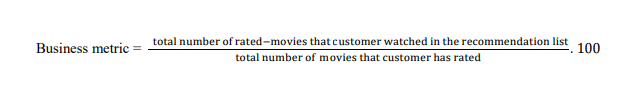


*   In the test set with 318 customers, the average business metrics is 32.60%.That means for every 100 movies rated by customers, an average of 33 movies are from the recommended list.

*   The table below demonstrates the percentage of customer who which are drawn from recommendation list out of 100 movies



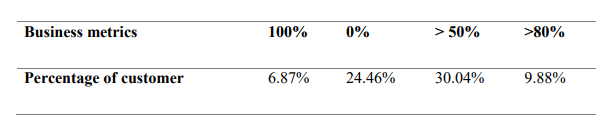

The first column demonstrates that there is 6.87% of customers equivalently to 22 clients in the test set who have rated movies and all these movies are exactly precise with the list of recommendation. The explanation is similar for other columns

In [ ]:
count_100 = 0
count_0 = 0
count_50 = 0
count_80 = 0
for i in value :
    if i == 100.0:
        count_100 +=1
    if i == 0.0:
        count_0 += 1
    if i >=50.0:
        count_50+=1
    if i >= 80.0:
        count_80 += 1

print('100% ', count_100/len(value) * 100)
print('0%    ', count_0/ len(value) * 100)
print('>=50% ', count_50/len(value) * 100)
print('>=80% ', count_80/len(value) * 100)

100%  6.866952789699571
0%     24.463519313304722
>=50%  30.042918454935624
>=80%  9.871244635193133


In [ ]:
import numpy as np
np.mean(value)

32.59656652360515